<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Python for Finance (2nd ed.)

**Mastering Data-Driven Finance**

&copy; Dr. Yves J. Hilpisch | The Python Quants GmbH

<img src="http://hilpisch.com/images/py4fi_2nd_shadow.png" width="300px" align="left">

# Trading Strategies (b)

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from pylab import mpl, plt
import warnings

In [2]:
warnings.simplefilter('ignore')
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
np.random.seed(1000)
%matplotlib inline

## Linear OLS Regression

This section aoolies linear OLS regression to predict the direction of the market movements based on historical log returns. To keep things simple, only two features are used. The first feature (lag_1) represents the log returns of the financial time series lagged by one day. The second feature (lag_2) lags the log returns by two days. Log returns - in contrast to prices - are stationary in general, which often is a necessary condition for the application of statistical and ML algorithms. 
The basic idea behind the usage of lagged log returns as features is that they might be informative in predicting future returns. For example, one might hipothesize that after two downward movements an upward movement is more likely ("mean reversion")  or, on the contrary, that another downward movement is more likely ("momentum" or "trend"). The application of regression techniques allows the formalization of such informal reasonings. 

### The Data

First, the importing and preparation of the dataset. The data shows the daily historical returns for the EUR/USD exchange rate. 

In [3]:
raw = pd.read_csv('http://hilpisch.com/tr_eikon_eod_data.csv',
                  index_col=0, parse_dates=True).dropna()

In [4]:
raw.columns

Index(['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', 'SPY', '.SPX', '.VIX',
       'EUR=', 'XAU=', 'GDX', 'GLD'],
      dtype='object')

In [5]:
symbol = 'EUR='

In [6]:
data = pd.DataFrame(raw[symbol])

In [7]:
data['returns'] = np.log(data / data.shift(1))

In [8]:
data.dropna(inplace=True)

In [9]:
data['direction'] = np.sign(data['returns']).astype(int)

In [10]:
data.head()

,EUR=,returns,direction
Date,,,
2010-01-05,1.4368,-0.002988,-1
2010-01-06,1.4412,0.003058,1
2010-01-07,1.4318,-0.006544,-1
2010-01-08,1.4412,0.006544,1
2010-01-11,1.4513,0.006984,1


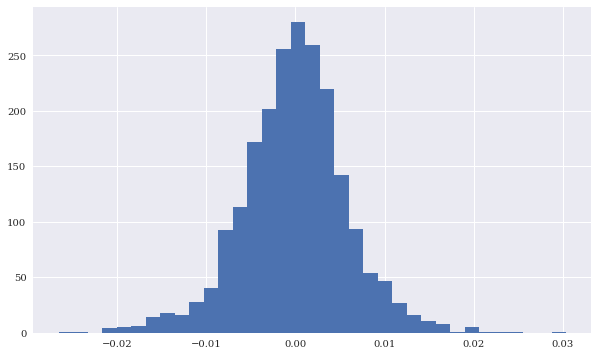

In [11]:
data['returns'].hist(bins=35, figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_01.png')

Figure: Histogram of the log returns for EUR/USD exchange rate. 

The following code creates the features data by lagging the log returns and visualizes it in combination with the returns data (See next Figure):

In [12]:
lags = 2

In [13]:
def create_lags(data):
    global cols
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['returns'].shift(lag)
        cols.append(col)

In [14]:
create_lags(data)

In [15]:
data.head()

,EUR=,returns,direction,lag_1,lag_2
Date,,,,,
2010-01-05,1.4368,-0.002988,-1,NaN,NaN
2010-01-06,1.4412,0.003058,1,-0.002988,NaN
2010-01-07,1.4318,-0.006544,-1,0.003058,-0.002988
2010-01-08,1.4412,0.006544,1,-0.006544,0.003058
2010-01-11,1.4513,0.006984,1,0.006544,-0.006544


In [16]:
data.dropna(inplace=True)

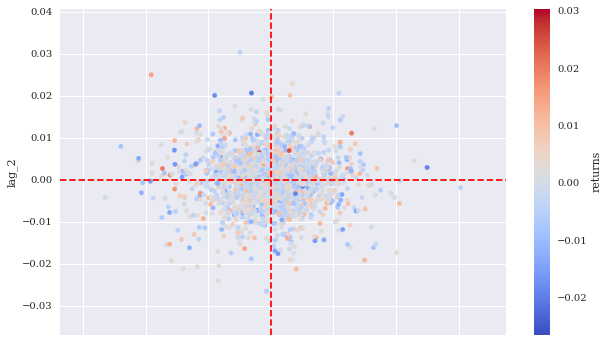

In [17]:
data.plot.scatter(x='lag_1', y='lag_2', c='returns', 
                  cmap='coolwarm', figsize=(10, 6), colorbar=True)
plt.axvline(0, c='r', ls='--')
plt.axhline(0, c='r', ls='--');
# plt.savefig('../../images/ch15/strat_ml_02.png');

Figure: Scatter plot based on features and labels data. 

### Regression

With the dataset completed, linear OLS regression can be applied to learn about any potential linear relationships, to predict markket movement based on the features and to backtest a trading strategy based on the predictions. Two basic approaches are available: using the log returns or only the direction data as the dependent variable during the regression. In any case, predictions are real-valued and therefore, transformed to either +1 or -1 to only work with the direction of the prediction. 

In [18]:
from sklearn.linear_model import LinearRegression  

In [19]:
model = LinearRegression()  

In [20]:
# The regression is implemented on the log returns directly
data['pos_ols_1'] = model.fit(data[cols], data['returns']).predict(data[cols])  

In [21]:
data['pos_ols_2'] = model.fit(data[cols], data['direction']).predict(data[cols])  

In [22]:
data[['pos_ols_1', 'pos_ols_2']].head()

,pos_ols_1,pos_ols_2
Date,,
2010-01-07,-0.000166,-0.000086
2010-01-08,0.000017,0.040404
2010-01-11,-0.000244,-0.011756
2010-01-12,-0.000139,-0.043398
2010-01-13,-0.000022,0.002237


In [23]:
# The real-valued predictions are transformed to directional values (+1, -1)
data[['pos_ols_1', 'pos_ols_2']] = np.where(
            data[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)  

In [24]:
data['pos_ols_1'].value_counts()  

-1    1847
 1     288
Name: pos_ols_1, dtype: int64

In [25]:
data['pos_ols_2'].value_counts()  

 1    1377
-1     758
Name: pos_ols_2, dtype: int64

The two approached yield different directional predictions in general. 

In [26]:
(data['pos_ols_1'].diff() != 0).sum()  

555

In [27]:
(data['pos_ols_2'].diff() != 0).sum()  

762

However, both lead to a relatevily large number of trades over time. 

Equiped with the directional prediction, vectorized backtesting can be applied to judge the performance of the resulting trading strategies. At this stage, the analysis is based on a number of simplifying assumptions, such as, "zero transaction costs" and the usage of the same dataset for both training and testing. Under these assumptions, however, both regression-bsaed strategies outperform and the benchmark passive investment, while only the strategy trained on the direction of the market shows a positive overall performance. 

In [28]:
data['strat_ols_1'] = data['pos_ols_1'] * data['returns']

In [29]:
data['strat_ols_2'] = data['pos_ols_2'] * data['returns']

In [30]:
data[['returns', 'strat_ols_1', 'strat_ols_2']].sum().apply(np.exp)

returns        0.810644
strat_ols_1    0.942422
strat_ols_2    1.339286
dtype: float64

In [31]:
(data['direction'] == data['pos_ols_1']).value_counts()  

False    1093
True     1042
dtype: int64

In [32]:
(data['direction'] == data['pos_ols_2']).value_counts()  

True     1096
False    1039
dtype: int64

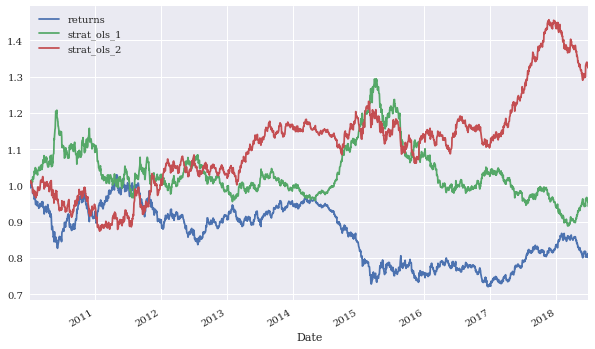

In [33]:
data[['returns', 'strat_ols_1', 'strat_ols_2']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_03.png');

Figure: Performance of EUR/USD and regression based strategies over time. 

## Clustering

This section applied k-means clustering, as introduced in "Machine Learning" to financial time series automatically come up with clusters that are used to formulate a trading strategy. The idea is that the algorithm identifies two clusters of feature values that predict either an upward movement or a downward movement. 

The following code applies k-means algorithm to the two features as used before. 

In [34]:
from sklearn.cluster import KMeans

In [35]:
model = KMeans(n_clusters=2, random_state=0)  #  <1>

In [36]:
model.fit(data[cols])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [37]:
data['pos_clus'] = model.predict(data[cols])

In [38]:
data['pos_clus'] = np.where(data['pos_clus'] == 1, -1, 1)  

In [39]:
data['pos_clus'].values

array([-1,  1, -1, ...,  1,  1, -1])

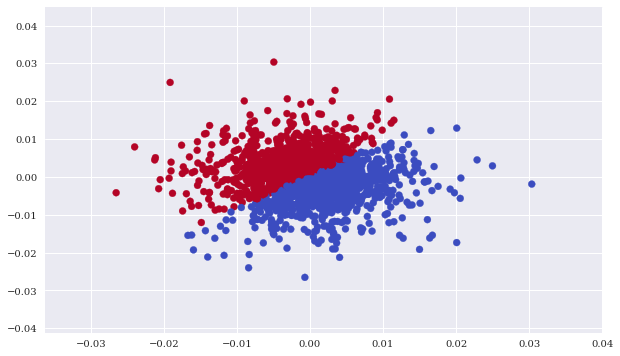

In [40]:
plt.figure(figsize=(10, 6))
plt.scatter(data[cols].iloc[:, 0], data[cols].iloc[:, 1],
            c=data['pos_clus'], cmap='coolwarm');
# plt.savefig('../../images/ch15/strat_ml_04.png');

Figure: Two clusters as identified by the k-means algorithm

Admittedly, this approach is quite arbitrary in this context - after all., how should the algorithm know what one is looking for? However, the resulting trading strategy shows a slight outperformance at the end compared to the benchmark passive investment. It is noteworthy that no guidance (supervision) is given and that the hit ratio- i.e. number of correct predictions in relationship to all predictions made - is less than 50%. 

In [41]:
data['strat_clus'] = data['pos_clus'] * data['returns']

In [42]:
data[['returns', 'strat_clus']].sum().apply(np.exp)

returns       0.810644
strat_clus    1.277133
dtype: float64

In [43]:
(data['direction'] == data['pos_clus']).value_counts()

True     1077
False    1058
dtype: int64

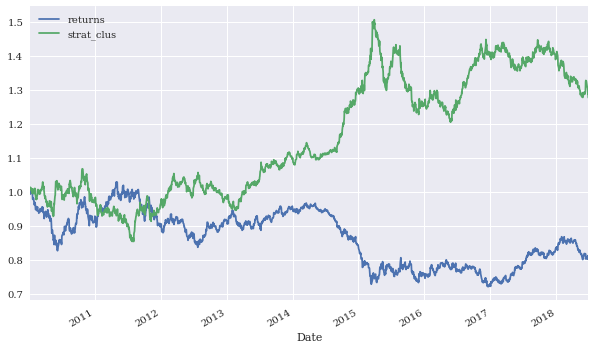

In [44]:
data[['returns', 'strat_clus']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_05.png');

Performance of the EUR/USD and k-means-based strategy over time. 

## Frequency Approach

Beyond more sophisticaed algorithms and techniques, one might come up with the idea of just implement a frequency approach to predict directional movements in financial markets. To this end, one might transform the two real-valued features to binary ones and asses the probability of an upward and a downward movement, respectively, from the historical observations of such movements, given the four posible combinations for the two binary features. 

In [45]:
# Digitalized the featuers values given the bins parameter
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)  
        cols_bin.append(col_bin)

In [46]:
create_bins(data)

In [47]:
# Shows the digitalized feature values and the label values. 
data[cols_bin + ['direction']].head()  

,lag_1_bin,lag_2_bin,direction
Date,,,
2010-01-07,1,0,-1
2010-01-08,0,1,1
2010-01-11,1,0,1
2010-01-12,1,1,-1
2010-01-13,0,1,1


In [48]:
# Shows the frequency of the possible movements conditional on the feature value combinations. 
grouped = data.groupby(cols_bin + ['direction'])
grouped.size()  

lag_1_bin  lag_2_bin  direction
0          0          -1           239
                       0             4
                       1           258
           1          -1           262
                       1           288
1          0          -1           272
                       0             1
                       1           278
           1          -1           278
                       0             4
                       1           251
dtype: int64

In [49]:
# Transforms the Dataframe object to have the frequencies in columns. 
res = grouped['direction'].size().unstack(fill_value=0)  

In [50]:
# HIghlights the highest-frequency value per feature value combination. 
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]  

In [51]:
res.style.apply(highlight_max, axis=1)  

In [52]:
# Translates the findings given the frequencies to a trading strategy.  
data['pos_freq'] = np.where(data[cols_bin].sum(axis=1) == 2, -1, 1)  

In [53]:
(data['direction'] == data['pos_freq']).value_counts()

True     1102
False    1033
dtype: int64

In [54]:
data['strat_freq'] = data['pos_freq'] * data['returns']

In [55]:
data[['returns', 'strat_freq']].sum().apply(np.exp)

returns       0.810644
strat_freq    0.989513
dtype: float64

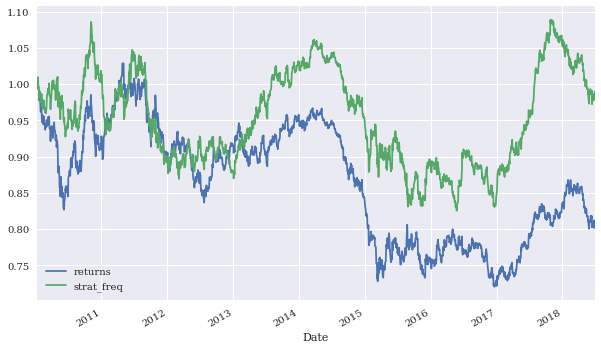

In [56]:
data[['returns', 'strat_freq']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_06.png');

Figure: Performance of the EUR/USD and frequency-nased trading strategy over time. 

## Classification Algorithms

This section applied the classification algorithms from ML to the problem of predicting the direction of the price movements in financial markets. WIth that background and the examples from previous sections, the application of the logistic regression, Gaussian Naive Bayes, SVM approaches is a straightforward as applying them to a smaller sample data sets. 

## Two Binary Features
First, a fitting of the models based on the binary feature values and the derivation of the resulting position values: 

In [57]:
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [58]:
C = 1

In [59]:
models = {
    'log_reg': linear_model.LogisticRegression(C=C),
    'gauss_nb': GaussianNB(),
    'svm': SVC(C=C)
}

In [60]:
def fit_models(data):  
    mfit = {model: models[model].fit(data[cols_bin], data['direction'])
            for model in models.keys()} 

In [61]:
# A functions that fits all models. 
fit_models(data)

In [62]:
# A function that derives all position values from the fitted models. 
def derive_positions(data):  
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])

In [63]:
derive_positions(data)

The vectorized backtesting of the resulting trading strategies visualizes the performance over time. 

In [64]:
# A function that evalues all resulting trading strategies. 
def evaluate_strats(data):  
    global sel
    sel = []
    for model in models.keys():
        col = 'strat_' + model 
        data[col] = data['pos_' + model] * data['returns']
        sel.append(col)
    sel.insert(0, 'returns')

In [65]:
evaluate_strats(data)

In [66]:
sel.insert(1, 'strat_freq')

In [67]:
# Some stratgies might show the exact same performance. 
data[sel].sum().apply(np.exp)  

returns           0.810644
strat_freq        0.989513
strat_log_reg     1.243322
strat_gauss_nb    1.243322
strat_svm         0.989513
dtype: float64

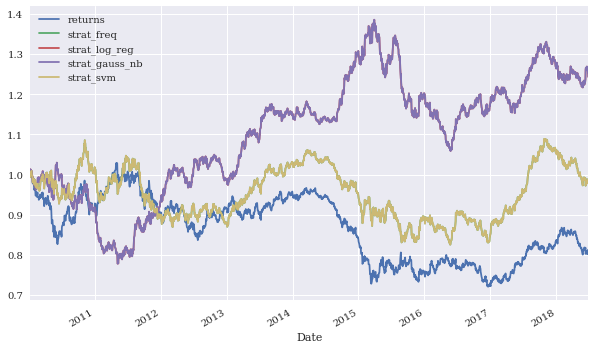

In [68]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_07.png')

Figure: Performance of the EUR/USD and classificaqtion-based trading strategies (two binary lags) over time. 

### Five Binary Features

In an attempt to improve the strategies' performance, the following code works with five binary lags instead of two. In particular, the performance of the SVM-based strategy is significantly improved. On ther other hand, the performance of the LR and GNB-based strategies is worse:

In [69]:
data = pd.DataFrame(raw[symbol])

In [70]:
data['returns'] = np.log(data / data.shift(1))

In [71]:
data['direction'] = np.sign(data['returns'])

In [72]:
lags = 5  
create_lags(data)
data.dropna(inplace=True)

In [73]:
create_bins(data)  
cols_bin

['lag_1_bin', 'lag_2_bin', 'lag_3_bin', 'lag_4_bin', 'lag_5_bin']

In [74]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-12,1,1,0,1,0
2010-01-13,0,1,1,0,1
2010-01-14,1,0,1,1,0
2010-01-15,0,1,0,1,1
2010-01-19,0,0,1,0,1


In [75]:
data.dropna(inplace=True)

In [76]:
fit_models(data)

In [77]:
derive_positions(data)

In [78]:
evaluate_strats(data)

In [79]:
data[sel].sum().apply(np.exp)

returns           0.805002
strat_log_reg     0.971623
strat_gauss_nb    0.986420
strat_svm         1.452406
dtype: float64

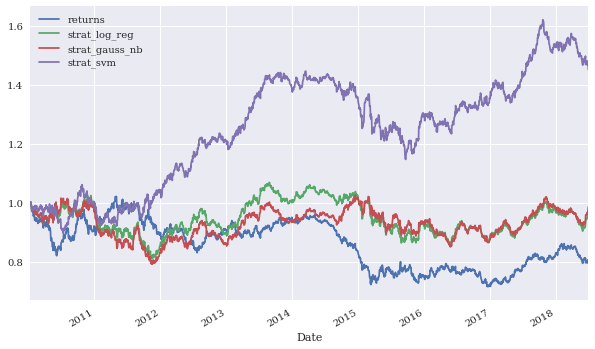

In [80]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_08.png');

Performance of EUR/USD and classification-based trading strategies (five binary lags) over time. 

### Five Digitized Features

Finally, the following code uses the first and second movement of the historical log returns to digitize the features data, allowing for more possible feature value combinations. This improves the performance of all classification algorithms used, but for SVM the improvement is again most pronounced. 

In [81]:
# The mean log return and the standard deviation are used to digitize the features data. 
mu = data['returns'].mean()  
v = data['returns'].std()  

In [82]:
bins = [mu - v, mu, mu + v]  
bins  

[-0.006033537040418658, -0.00010174015279231318, 0.005830056734834032]

In [83]:
create_bins(data, bins)

In [84]:
data[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-12,3,3,0,2,1
2010-01-13,1,3,3,0,2
2010-01-14,2,1,3,3,0
2010-01-15,1,2,1,3,3
2010-01-19,0,1,2,1,3


In [85]:
fit_models(data)

In [86]:
derive_positions(data)

In [87]:
evaluate_strats(data)

In [88]:
data[sel].sum().apply(np.exp)

returns           0.805002
strat_log_reg     1.431120
strat_gauss_nb    1.815304
strat_svm         5.653433
dtype: float64

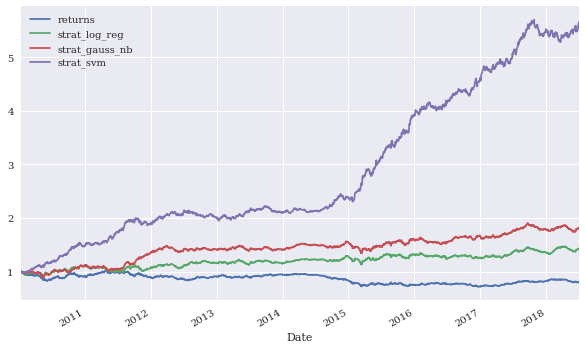

In [89]:
data[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_09.png')

Perforamnce of the EUR/USD and classification based trading strategies (five digitized lags) over time. 

#### Types of features
This chapter exclusively works with lagged return data as features data, mostly in binarized or digitized form. This is mainly done for convenience, since such featues data can be derived from the financial time series itself. However. in practical applications he features data can be gained from a wealth of different data sources and might include other financial time series and statistics derived thereof, macroeconomic data, company financial indicators, or news articles. There are also Python packaged for automated time series feature extraction available, such as tsfresh. 

### Sequential Train-Test Split

To better judge the perforamnce of the classification algorithms, the code that follows implements a sequential train-test split. Tje idea here is to simulate the situation where only data up to a certain point in time is available on which to train an ML algorithm. During live trading, the algorithm is then faced with data it has never seen before. This is where the algorithm must prove its worth. In this particular case, all classification algorithms outperformed - under the simplified assumptions from before - the passive benchmark investment, but only the GNB and LR algorithms achieve a positive absolute performance. 

In [90]:
split = int(len(data) * 0.5)

In [91]:
# Trains all classification algorithms on the training data. 
train = data.iloc[:split].copy()  

In [92]:
fit_models(train)  

In [93]:
# Test all classification algorithms on the test data. 
test = data.iloc[split:].copy()  

In [94]:
derive_positions(test)  

In [95]:
evaluate_strats(test)  

In [96]:
test[sel].sum().apply(np.exp)

returns           0.850291
strat_log_reg     0.962989
strat_gauss_nb    0.941172
strat_svm         1.048966
dtype: float64

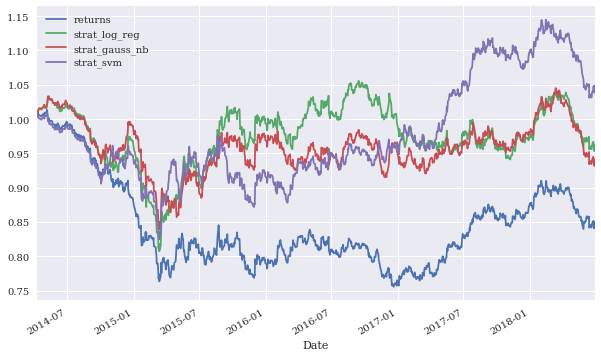

In [97]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_10.png');

Figure: Perforamnce of EUR/USD and classification-based trading strategies (sequential train-test split)

### Randomized Train-Test Split

The classification algorithms are trained and tested on binary or digitized features data. The idea is that the feature value patterns allow a prediction of future market movements with a better hit ratio than 50%. Implicitly, it is assumed that the patterns' predictive power persists over time. In that sense, it shouldnt make (too much of) a difference on which part of the data an algorithm is trained and on which part of the data it is tested- implying that one can break up the temporal sequence of the data for training and testing. 

A tipical way to do this is a randomized train-test split to test the performance of the classification algorithms out-of-sample-- again trying to emulate reality, where an algorithm during trading is faced with new data on a continious basis. The approach used is the same as that applied to the samople data in "Train-Test splits: SVM". Based on this approach, the SVM algorithm shows again the best performance out-of-sample. 

In [98]:
from sklearn.model_selection import train_test_split

In [99]:
train, test = train_test_split(data, test_size=0.5,
                               shuffle=True, random_state=100)

In [100]:
train = train.copy().sort_index()  

In [101]:
train[cols_bin].head()

,lag_1_bin,lag_2_bin,lag_3_bin,lag_4_bin,lag_5_bin
Date,,,,,
2010-01-12,3,3,0,2,1
2010-01-13,1,3,3,0,2
2010-01-14,2,1,3,3,0
2010-01-15,1,2,1,3,3
2010-01-20,1,0,1,2,1


In [102]:
test = test.copy().sort_index()  

In [103]:
fit_models(train)

In [104]:
derive_positions(test)

In [105]:
evaluate_strats(test)

In [106]:
test[sel].sum().apply(np.exp)

returns           0.878078
strat_log_reg     0.735893
strat_gauss_nb    0.765009
strat_svm         0.695428
dtype: float64

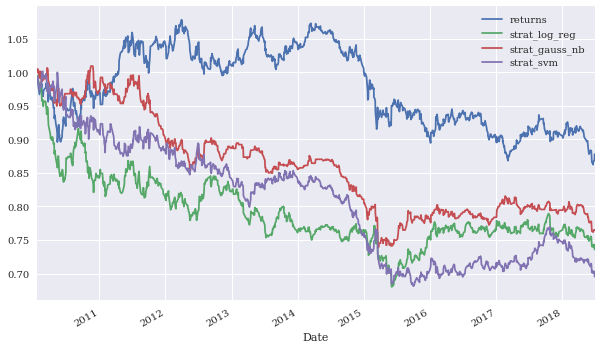

In [107]:
test[sel].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_11.png');

Performance of EUR/USD and classification-based trading strategies (randomized train-test split)

## Deep Neural Network

Deep neural networks (DNNs) try to emulate the functioning of the human brain. They are in general composed of an input layer (features) , an output layer (the labels) and a number of hidden layers. The presence of hidden layers is what makes a neural network deep. It allows it to learn more complex relationships and to perform better on a number of problem types. When applying DNNs one generally speaks of deep learning instead of machine learning. For an introduction to this field, refer to Geron or Gibson and Patterson (2017).

### DNN with scikit-learn

This section applies the MLPClassifier algorithm from sci-kjit learn, as introduced in DNN. First, it is trained and tested on the whole dataset, using digitized features. The algorithm achieved exceptional performance in-sample which illustrates the power of DNNs for this type of problem. It also hints a strong overfitting, since the performance indeed seems unrealistically good:

In [108]:
from sklearn.neural_network import MLPClassifier

In [109]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=2 * [250], random_state=1)

In [110]:
%time model.fit(data[cols_bin], data['direction'])

CPU times: user 18.7 s, sys: 668 ms, total: 19.4 s
Wall time: 7.08 s


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[250, 250], learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [111]:
data['pos_dnn_sk'] = model.predict(data[cols_bin])

In [112]:
data['strat_dnn_sk'] = data['pos_dnn_sk'] * data['returns']

In [113]:
data[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

returns          0.805002
strat_dnn_sk    39.953203
dtype: float64

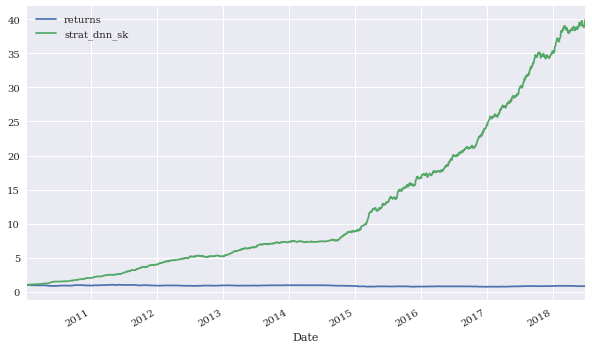

In [114]:
data[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_12.png');

Figure: Performance of EUR/USD and DNN-based on trading strategy (sci-kit learn, in-sample).

To avoid overfitting of the DNN, a randomized train test split is the applied next step. 

In [115]:
train, test = train_test_split(data, test_size=0.5, random_state=100)

In [116]:
train = train.copy().sort_index()

In [117]:
test = test.copy().sort_index()

In [118]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=500,
                     hidden_layer_sizes=3 * [500], random_state=1)  

In [119]:
%time model.fit(train[cols_bin], train['direction'])

CPU times: user 2min 48s, sys: 7.26 s, total: 2min 56s
Wall time: 1min 1s


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[500, 500, 500], learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [120]:
test['pos_dnn_sk'] = model.predict(test[cols_bin])

In [121]:
test['strat_dnn_sk'] = test['pos_dnn_sk'] * test['returns']

In [122]:
test[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

returns         0.878078
strat_dnn_sk    1.183200
dtype: float64

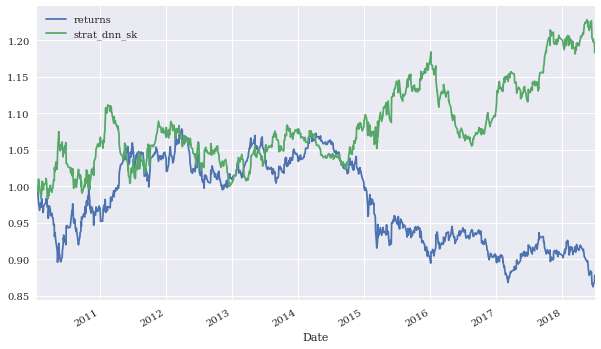

In [123]:
test[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_13.png');

Figure: Performance of EUR/USD and DNN-based trading strategy. (scikit-learn, randomized train-test split)

### DNN with Keras & TensorFlow Backend

In [124]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [125]:
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential

In [126]:
def create_model():
    np.random.seed(100)
    tf.random.set_seed(100)
    model = Sequential()
    model.add(Dense(16, activation='relu', input_dim=lags))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

In [127]:
data_ = (data - data.mean()) / data.std()
data['direction_'] = np.where(data['direction'] == 1, 1, 0)

In [128]:
model = create_model()

In [129]:
%%time
model.fit(data_[cols], data['direction_'],
          epochs=50, verbose=False)

CPU times: user 3.81 s, sys: 462 ms, total: 4.27 s
Wall time: 2.73 s


In [130]:
model.evaluate(data_[cols], data['direction_'])

67/67 [==============================] - 0s 642us/step - loss: 0.6698 - accuracy: 0.5793


[0.6697988510131836, 0.5792682766914368]

In [131]:
pred = np.where(model.predict(data_[cols]) > 0.5, 1, 0) 
pred[:10].flatten()

array([0, 1, 0, 1, 0, 1, 0, 0, 1, 1])

In [132]:
data['pos_dnn_ke'] = np.where(pred > 0, 1, -1)  

In [133]:
data['strat_dnn_ke'] = data['pos_dnn_ke'] * data['returns']

In [134]:
data[['returns', 'strat_dnn_ke']].sum().apply(np.exp)

returns         0.805002
strat_dnn_ke    5.371421
dtype: float64

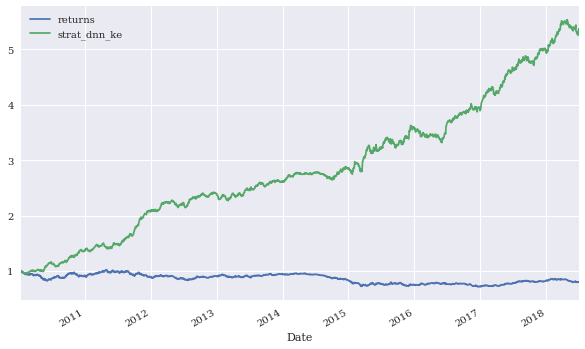

In [135]:
data[['returns', 'strat_dnn_ke']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_14.png');

Figure: Performance of the EUR/USD and DNN-based trading strategy (Tensorflow, in-sample)

THe following code again implements a randomized train-test split to a get a more relistic view of the performance of the DNN-based algorithmic trading strategy. 

In [136]:
mu, std = train.mean(), train.std()

In [137]:
train_ = (train - mu) / mu.std()

In [138]:
model = create_model()

In [139]:
train['direction_'] = np.where(train['direction'] > 0, 1, 0)

In [140]:
%%time
model.fit(train_[cols], train['direction_'],
          epochs=50, verbose=False)

CPU times: user 2.14 s, sys: 249 ms, total: 2.39 s
Wall time: 1.62 s


In [141]:
test_ = (test - mu) / std

In [142]:
test['direction_'] = np.where(test['direction'] > 0, 1, 0)

In [143]:
model.evaluate(test_[cols], test['direction_'])

34/34 [==============================] - 0s 713us/step - loss: 1.0210 - accuracy: 0.4916


[1.0209919214248657, 0.49155721068382263]

In [144]:
pred = np.where(model.predict(test_[cols]) > 0.5, 1, 0) 
pred[:10].flatten()

array([0, 1, 0, 0, 0, 0, 1, 0, 0, 0])

In [145]:
test['pos_dnn_ke'] = np.where(pred > 0, 1, -1)

In [146]:
test['strat_dnn_ke'] = test['pos_dnn_ke'] * test['returns']

In [147]:
test[['returns', 'strat_dnn_sk', 'strat_dnn_ke']].sum().apply(np.exp)

returns         0.878078
strat_dnn_sk    1.183200
strat_dnn_ke    1.155670
dtype: float64

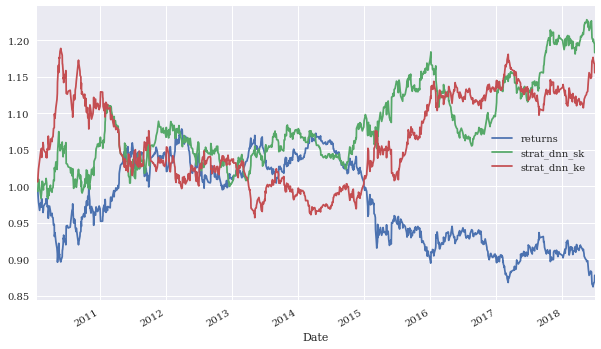

In [148]:
test[['returns', 'strat_dnn_sk', 'strat_dnn_ke']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));
# plt.savefig('../../images/ch15/strat_ml_15.png');

Figure: Performance of the EUR/USD and DNN-based trading strategy (Tensorflow, randomized train-test split)

#### Performance Results
All performance results shown for the different algorithmic trading strategies from vectorized backtesting so far are illustrative only. Beyond the simplifying assumption of no transaction costs, tne results depend on a number of other (mostly arbitrary chosen) paramters. They also depend on the relative small end-of-day price data set used throughout for the EUR/USD exchange rate. The focus lies on illustrating the application of different approaches and ML algorithms to financial data, not on deriving a robust algorithmic trading strategy to be deployed in practice. The next chapter addresses of these issues. 

### Conclusion
This chapter is about algorithmic trading strategies and judging their performance based on vectorized backtesting. It starts with a rather simple algorithmic tading strategy based on two simple moving averages, a type of strategy known and used in practice for decades. This strategy is used to ullustrate vectorized backtesting, making heavy use of the vectorization capabilities of Numpy and pandasfor data analysis. 

Using OLS regression, the chapter also illustrats the random walk hypothesis on the basis of a real financial time series. This is the banchmark ahainst any algorithmic trading strategy must prove its worth. 

The core of the fchapter is the application of ML algorithms, the majority which are of classification type, are used and applied based on mostly the same rythm. As features, lagged log returns data is used in a number of variants - although this is a restriction that for sure is not necessary. It is mostly done for convenience and simplicity. In addition, the analysis bsed on a number of simplifying assumptions since the focus is mainly on the technical saspects of applying ML algorithms to financial time series data to predict the direction of financial market movements. 